In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
%matplotlib inline
from tabulate import tabulate

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pdtabulate=lambda df:tabulate(df,headers='keys',tablefmt='psql')

In [3]:
def load_data(dataset='100k'):
    if dataset=='100k' or dataset==0:
        df = pd.read_csv('data/ml-100k/u.item',encoding='latin-1',sep='|',header=None,names=['movie_id','movie_title','release_date','video_release_date','IMDb URL','unknown','action','adventure','animation','children\'s','comedy','crime','documentary','drama','fantasy','film-noir','horror','musical','mystery','romance','sci-fi','thriller','war','western'])
        id_to_title = dict(zip(df.movie_id,df.movie_title))
        df = pd.read_csv('data/u.data',sep='\t',header=None,names=['user_id','movie_id','rating','timestamp'])
    if dataset=='1M' or dataset==1:
        df = pd.read_csv('data/ml-1m/movies.dat',encoding='latin-1',sep='::',header=None, names=['movie_id','movie_title','trash'])
        id_to_title = dict(zip(df.movie_id,df.movie_title))
        df = pd.read_csv('data/ml-1m/ratings.dat', header=None, sep='::', names=['user_id','movie_id','rating','timestamp'])
            
    df = df.drop('timestamp', axis=1)
    print('rating values:',np.unique(df.rating))
    print('Initial number of films:', len(np.unique(df.movie_id)))
    print('Initial number of users:',len(np.unique(df.user_id)))
    movie_hist = df.groupby('movie_id').count().rating
    user_hist = df.groupby('user_id').count().rating
    df = df[ df.movie_id.isin( movie_hist[movie_hist >20].index ) ]
    df = df[ df.user_id.isin( user_hist[user_hist >20].index ) ]
    return df, id_to_title

df,_ = load_data(1)

C:\Users\Alfons\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys
C:\Users\Alfons\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


rating values: [1 2 3 4 5]
Initial number of films: 3706
Initial number of users: 6040


In [47]:
#train-test split, so that test contains one rating from each user
def split_df(df, rating_threshold=3):
    df = df[df.rating>rating_threshold]
    user_list = np.unique(df.user_id)
    train =  pd.DataFrame({'user_id': [], 'movie_id':[], 'rating':[]}).astype('int32')
    test = pd.DataFrame({'user_id': [], 'movie_id':[], 'rating':[]}).astype('int32')
    train_list = []
    test_list = []
    for user_id in user_list:
        df_reduced = df[df.user_id==user_id]
        test_i = df_reduced.sample()
        train_i = df_reduced.drop(test_i.index)
        train_list.append(train_i)
        test_list.append(test_i)
    train = pd.concat(train_list)
    test = pd.concat(test_list) 
    return train, test
train, test = split_df(df, 0)

In [4]:
data = pd.DataFrame({'movie_id':[1,1,1,2,2,2,3,3,3,4,4,4,5,5,5], 'user_id':[1,2,4,1,3,4,2,3,4,1,2,3,1,2,3], 'rating':[1,2,3,4,3,1,5,4,3,5,2,3,4,2,2]})
data_ratings = data.pivot_table(values='rating',columns='user_id',index='movie_id')

data_ratings.values

array([[ 1.,  2., nan,  3.],
       [ 4., nan,  3.,  1.],
       [nan,  5.,  4.,  3.],
       [ 5.,  2.,  3., nan],
       [ 4.,  2.,  2., nan]])

In [4]:
from time import time
from scipy.sparse import csr_matrix, csc_matrix
from sklearn.linear_model import SGDRegressor, ElasticNet




class MatrixSparseColumn():
    def __init__(self, X_csr):
        self.X_csr = X_csr
        X_csc = X_csr.copy()
        X_csc.data = np.arange(X_csr.nnz)
        self.X_csc = X_csc.tocsc()
        
    def get_col(self, col_idx):
        col = self.X_csc[:, col_idx].copy()
        col.data = self.X_csr.data[col.data]
        return col

#         dataptr = self.col_view[:,j].data
#         self.X.data[dataptr] = vals
    def update_col(self, vals, col_idx):
        idx = self.X_csc[:, col_idx].data
        self.X_csr.data[idx] = vals
        return 



class slimRecommender():
    
    def __init__(self):
        self.empty = None

    #creating training matrix
    def df_to_csr(self,df):
        data = df.rating
        columns = df.movie_id-1
        rows = df.user_id-1
        shape = (max(df.user_id), max(df.movie_id))

        user_list = np.unique(df.user_id)
        movie_list = np.unique(df.movie_id)
        
        A= csr_matrix((data, (rows, columns)), shape=shape)
        return A, user_list, movie_list
    
    def compute_similarity_vec(self, msc, col_idx, l1_reg=0.001, l2_reg=0.0001):
#         l1_reg=0.001
#         l2_reg= 0.0001
        fit_intercept=False
        num_selected_features=200
        alpha = l1_reg+l2_reg
        if alpha==0:
            l1_ratio = 0
            model = SGDRegressor(penalty='elasticnet',fit_intercept=fit_intercept,alpha=alpha,l1_ratio=l1_ratio)
        else:
            l1_ratio = l1_reg/alpha
            model = ElasticNet(alpha=alpha,l1_ratio=l1_ratio,positive=True,fit_intercept=fit_intercept,copy_X=False)

        
        a = msc.get_col(col_idx)
        msc.update_col(np.zeros(a.nnz), col_idx)
        model.fit( msc.X_csr, a.toarray().ravel())
        msc.update_col(a.data, col_idx)
        w = model.coef_
        w[w<0] = 0
        return w
    
    def fit(self, df, l1_reg=0.001, l2_reg= 0.0001):
        A, self.user_list, self.movie_list = self.df_to_csr(df)
        self.msc = MatrixSparseColumn(A)
        
        row = []
        col = []
        data = []
        shape = (max(self.movie_list), max(self.movie_list))

        for movie_id in self.movie_list:
            movie_id = movie_id-1
            w = self.compute_similarity_vec(self.msc, movie_id, l1_reg, l2_reg)
            for row_idx,rating in enumerate(w):
                if rating !=0:
                    data.append(rating)
                    row.append(row_idx)
                    col.append(movie_id)
                
        self.sim_mat = csr_matrix((data, (row, col)), shape =  shape)
        return
    
    def recommend_to_user(self, A, user_id, k_items=10):
        user_idx = user_id - 1
        r = (A[user_idx]*self.sim_mat).toarray().flatten()
        movies_rated_by_user = np.unique(A[user_idx].indices)
        rec_list = []
        rec_ratings  = []
        for movie_idx in r.argsort()[::-1]:
            movie_id = movie_idx+1
            if movie_id not in movies_rated_by_user :
                rec_list.append(movie_id)
                rec_ratings.append(r[movie_idx])
            if len(rec_list) >= k_items:
                break
        return rec_list, rec_ratings
    
    def evaluate(self, df_test, k_items=10, rating=4, perRatingORcumulative=0):
        if perRatingORcumulative==0 or perRatingORcumulative=='rHR':
            df_test = df_test[df_test.rating==rating]
        if perRatingORcumulative==1 or perRatingORcumulative=='cHR':
            df_test = df_test[df_test.rating>=rating]
            
        user_list = np.unique(df_test.user_id)
        hr = 0
        for user_id in user_list:
            movie_test_id = df_test[df_test.user_id==user_id].movie_id.values[0]
            rec_list,_ = self.recommend_to_user(self.msc.X_csr, user_id, k_items=k_items)
            if movie_test_id in rec_list:
                hr += 1
        hr = hr/len(user_list)
        return hr
    


###  Some calculations

In [84]:
from time import time

heatmap_time = {}
base_list = np.array([0.5, 1., 2., 3.])
l1_list = base_list 
l2_list = base_list
# time_mtx = np.zeros(len(base_list), len(base_list))
# chr_mtx = np.zeros(len(base_list), len(base_list))

beta_megalist = []
lambda_megalist = []
time_list = []
chr_list = []

for idx_l1, l1 in enumerate(l1_list):
    for idx_l2, l2 in enumerate(l2_list):
        print(idx_l1, idx_l2, end=' ')
        sr = slimRecommender()
        train_time = time()
        sr.fit(train, l1_reg=l1, l2_reg=l2)
        train_time = time() -  train_time
        print('Train time:{:.3f}'.format(train_time))
        hr = sr.evaluate(test, k_items=10, rating=4, perRatingORcumulative='cHR')
        
        beta_megalist.append(l2)
        lambda_megalist.append(l1)
        time_list.append(train_time)
        chr_list.append(hr)

results_heatmap = pd.DataFrame({'Lambda': lambda_megalist, 'Beta': beta_megalist, 'Train Time': time_list, 'cHR': chr_list})

0 0 Train time:226.630
0 1 Train time:236.931
0 2 Train time:232.516
0 3 Train time:229.719
1 0 Train time:205.016
1 1 Train time:210.577
1 2 Train time:205.963
1 3 Train time:203.349
2 0 Train time:195.650
2 1 Train time:195.767
2 2 Train time:194.932
2 3 Train time:193.968
3 0 Train time:190.534
3 1 Train time:192.162
3 2 Train time:192.639
3 3 Train time:191.508


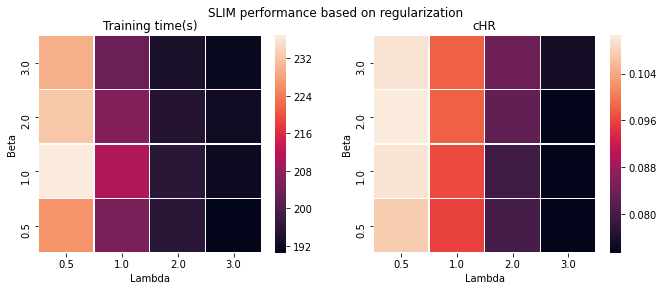

In [85]:
import seaborn as sns

time_hm = results_heatmap.pivot_table(index='Beta', columns='Lambda', values='Train Time' ).sort_index(ascending=False)
chr_hm = results_heatmap.pivot_table(index='Beta', columns='Lambda', values='cHR' ).sort_index(ascending=False)

fig,ax = plt.subplots(1,2, figsize=(11,4))
fig.suptitle('SLIM performance based on regularization')
ax[0].set_title('Training time(s)')
ax[1].set_title('cHR')
g1 = sns.heatmap(time_hm, linewidth=0.3, ax=ax[0])
g2 = sns.heatmap(chr_hm, linewidth=0.5, ax=ax[1])
plt.show()

In [51]:
chr_hm

Lambda,0.5,1.0,2.0,3.0
Beta,,,,
3.0,0.092423,0.081677,0.069049,0.016926
2.0,0.094304,0.080333,0.068243,0.016926
1.0,0.093229,0.078990,0.069318,0.016926
0.5,0.095110,0.078721,0.069586,0.016926


In [55]:
sr = slimRecommender()
train_time = time()
sr.fit(train)
train_time = time() -  train_time
print('Train time:{:.3f}'.format(train_time))

rating_list = [1,2,3,4,5]
type_rating_list = ['rHR','cHR']

ratings =  []
types = []
scores = []
for rating in rating_list:
    for typee in type_rating_list:
        print('rating:',rating, 'typee:', typee)
        hr = sr.evaluate(test, k_items=10, rating=rating, perRatingORcumulative=typee)
        ratings.append(rating)
        types.append(typee)
        scores.append(hr)
        
results_Scores = pd.DataFrame({'rating': ratings, 'Type HR': types, 'Value': scores})

Train time:509.610
rating: 1 typee: rHR
rating: 1 typee: cHR
rating: 2 typee: rHR
rating: 2 typee: cHR
rating: 3 typee: rHR
rating: 3 typee: cHR
rating: 4 typee: rHR
rating: 4 typee: cHR
rating: 5 typee: rHR
rating: 5 typee: cHR


In [62]:
results_Scores
chr_df = results_Scores.pivot_table(columns='Type HR', index='rating', values='Value')
chr_df

Type HR,cHR,rHR
rating,,
1,0.086329,0.003534
2,0.090460,0.032787
3,0.096642,0.047093
4,0.114536,0.080546
5,0.158537,0.158537


<function matplotlib.pyplot.show(*args, **kw)>

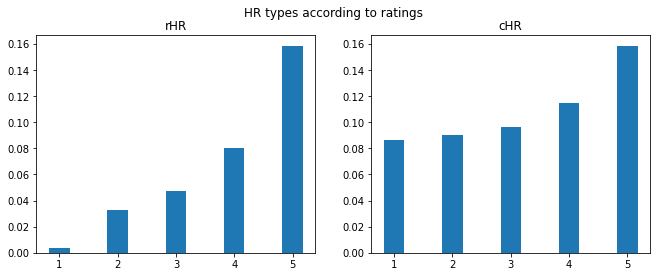

In [72]:

width=0.35
x = np.arange(len(chr_df)) + width/2
fig, ax = plt.subplots(1, 2, figsize=(11,4))
fig.suptitle('HR types according to ratings')
ax[0].set_title('rHR')
ax[0].bar(x, chr_df['rHR'], width)
ax[0].set_xticks(x)
ax[0].set_xticklabels(chr_df.index)
ax[1].set_title('cHR')
ax[1].bar(x, chr_df['cHR'], width)
ax[1].set_xticks(x)
ax[1].set_xticklabels(chr_df.index)

plt.show

In [73]:
sr = slimRecommender()
train_time = time()
sr.fit(train)
train_time = time() -  train_time
print('Train time:{:.3f}'.format(train_time))

k_list = [5,10,20,50,100]

scores = []
for k in k_list:
        print('k:',k)
        hr = sr.evaluate(test, k_items=k, rating=5)
        scores.append(hr)
        
results_Scores = pd.DataFrame({'Top-k': k_list, 'cHR': scores})

Train time:437.172
k: 5
k: 10
k: 20
k: 50
k: 100


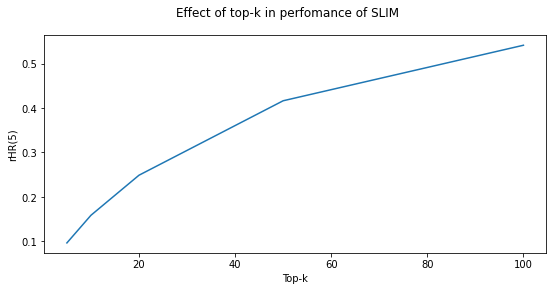

In [83]:
results_Scores
fig,ax = plt.subplots(figsize=(9,4))
fig.suptitle('Effect of top-k in perfomance of SLIM')
ax.plot(results_Scores['Top-k'], results_Scores['cHR'])
ax.set_xlabel('Top-k')
ax.set_ylabel('rHR(5)')
plt.show()

In [6]:
from time import time

def split_df(df, train_ratio=0.9):
    mask = np.random.rand(len(df)) < train_ratio
    train = df[mask]
    return train


ratio_list =np.linspace(0.1,0.9,9)

ts = []
ns = []
for ratio in ratio_list:
    print('ratio:', ratio, end=' ')
    train = split_df(df, train_ratio=ratio)
    n = len(train)
    ns.append(n)
    sr = slimRecommender()
    t = time()
    sr.fit(train)
    t = time() - t
    ts.append(t)
    print('t:', t)

result_com = pd.DataFrame({'N': ns, 'Time':ts})

ratio: 0.1 t: 44.637003660202026
ratio: 0.2 t: 72.00822329521179
ratio: 0.30000000000000004 t: 113.90211534500122
ratio: 0.4 t: 163.27509951591492
ratio: 0.5 t: 221.5709879398346
ratio: 0.6 t: 230.9002821445465
ratio: 0.7000000000000001 t: 254.63445520401
ratio: 0.8 t: 313.78670287132263
ratio: 0.9 t: 386.5850155353546


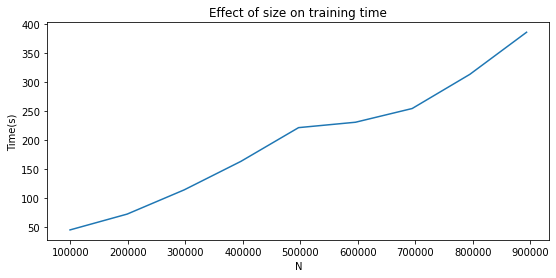

In [7]:
fig, ax = plt.subplots(figsize=(9,4))
ax.set_title('Effect of size on training time')
ax.set_xlabel('N')
ax.set_ylabel('Time(s)')
ax.plot(result_com.N,result_com.Time )